In [1]:
import matplotlib.pyplot as plt;
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier

In [2]:
##--------------------------------------------------------------------DATA-----------------------------------------------------------##

path=r''
traData = pd.read_csv(path+'trainingGroup.csv',index_col=None, header=None)
#traData = pd.read_csv('D:\\drive\\publications_2017\\datasets\\NSL-KDD\\NSL-KDD\\testingData.csv'  , index_col = None , header = None)
tesData = pd.read_csv(path+'testingGroup.csv',index_col=None, header=None)
target = 41

y_train = traData[[target]].values.reshape(len(traData)) 
x_train = preprocessing.normalize(traData.iloc[:,:-1])

y_test = tesData[[target]].values.reshape(len(tesData)) 
x_test = preprocessing.normalize(tesData.iloc[:,:-1])

def chooseObsMan(dic_f):
    chosenIDs=np.array(())
    for k,d in dic_f.items():
        temp=np.where(y_train==k)[0]
        z=np.random.choice(temp,dic_f[k],replace=False)
        chosenIDs=np.concatenate((chosenIDs,z))
    return np.int64(chosenIDs)
def label_index(row,threshold=0):
    
    if threshold==0:
        threshold=np.max(row)
    temp_i=np.where(row>=threshold)[0]
    if temp_i.shape[0]>0:
        return temp_i[0]+1
    else:
        return -1

In [3]:
labelled=np.zeros(x_train.shape[0])
labelled[:]=-1
li={1:60,2:60,3:30,4:10,5:10}
labelledIndex=chooseObsMan(li)
labelled[labelledIndex]=y_train[labelledIndex]

In [4]:
##--------------------------------------------------------------------Our MODULE-----------------------------------------------------------##


clfs ={}
clf1=BernoulliNB()
clf2=KNeighborsClassifier(n_jobs=-1)
clf3=RandomForestClassifier ( n_estimators = 20 , random_state = 0 ,n_jobs=-1)
clf4=SVC(kernel='rbf', probability=True)
clf5=tree.DecisionTreeClassifier()
clf7=AdaBoostClassifier()
clf8=QuadraticDiscriminantAnalysis()

#clfs=[('NB', clf1),('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('NB', clf1), ('KNN', clf2), ('RFC', clf3), ('SVC', clf4)]
#clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('KNN', clf2), ('RFC', clf3), ('j48', clf5)]
clfs1=[('NB', clf1),('j48', clf5), ('RFC', clf3)]
#clfs=[('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4)]
clfs2=[('NB', clf1)]


#Model1
threshold=0.99
leftNumber=-1
temp_left_Group=np.arange(x_train.shape[0])
for i in range(0,x_train.shape[0]):
    temp_left=sum(labelled==-1)
    if temp_left<=0:
        break;
    ensemble_models = VotingClassifier(estimators=clfs2, voting='soft')
    #print(x_train[labelled!=-1].shape)
    ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
    predicted=ensemble_models.predict_proba(x_train[labelled==-1])
    final_decition=np.apply_along_axis(label_index, 1, predicted,threshold)
    labelled[labelled==-1]=final_decition
    if temp_left==leftNumber:
        threshold-0.01
    threshold_step=0.1
    leftNumber=temp_left
    temp_left=sum(labelled==-1)
    temp_left_Group[i]=temp_left
    #print([temp_left,threshold])
    #print(temp_left, threshold, (final_decition != -1).mean() *400000 , (predicted != -1).mean() *400000)
    if i >0:
        change_rate=temp_left_Group[i-1] - temp_left_Group[i]
        if(change_rate<1000):
            threshold=threshold-threshold_step

#print(i)

print("------------------------------------Our Module---------------------------------------")
print('threshold step=',threshold_step)


print('\n*********Training*********\n')
        
pre=labelled[labelled!=-1]
org=y_train[labelled!=-1]
pop=metrics.precision_recall_fscore_support(org, pre,labels=[1, 2, 3,4, 5])
results = pd.DataFrame();
for i in range(0,len(pop)):
    temp = pd.DataFrame([pop[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    results=results.append(temp, ignore_index=True)

#print(len(clfs1),'Classifier')

results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(results)
resultsDataFrame1 = results
correctLabelled=metrics.accuracy_score(org, pre,normalize=False)
incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
print([correctLabelled,incorrectLabelled])
ourModelTrainingAcc = correctLabelled/(correctLabelled + incorrectLabelled)

numbers=results.iloc[3,1:]
correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
results1 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results1['Total'] = numbers
results1['Correct'] = correctLabelledForEachclass
results1['Incorrect'] = incorrectLabelledForEachclass
print(results1)


print('\n*********Testing*********\n')

def chooseObsManTest(dic_f):
    chosenIDs=np.array(())
    for k,d in dic_f.items():
        temp=np.where(y_test==k)[0]
        z=np.random.choice(temp,dic_f[k],replace=False)
        chosenIDs=np.concatenate((chosenIDs,z))
    return np.int64(chosenIDs)

labelledTest=np.zeros(x_test.shape[0])
labelledTest[:]=-1
li={1:60,2:60,3:30,4:10,5:10}
labelledIndexTest=chooseObsManTest(li)
labelledTest[labelledIndexTest]=y_test[labelledIndexTest]

leftNumberTest=-1
temp_left_GroupTest=np.arange(x_test.shape[0])
for i in range(0,x_test.shape[0]):
    temp_leftTest=sum(labelledTest==-1)
    if temp_leftTest<=0:
        break
    #ensemble_models = VotingClassifier(estimators=clfs2, voting='soft')
    #ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
    predictedTest=ensemble_models.predict_proba(x_test[labelledTest==-1])
    final_decitionTest=np.apply_along_axis(label_index, 1, predictedTest,threshold)
    labelledTest[labelledTest==-1]=final_decitionTest
    if temp_left==leftNumber:
        threshold-0.01
    threshold_step=0.01
    leftNumberTest=temp_leftTest
    temp_leftTest=sum(labelledTest==-1)
    temp_left_GroupTest[i]=temp_leftTest
    #print([temp_left,threshold])
    if i >0:
        change_rate=temp_left_Group[i-1] - temp_left_Group[i]
        if(change_rate<1000):
            threshold=threshold-threshold_step

preTest=labelledTest[labelledTest!=-1]
orgTest=y_test[labelledTest!=-1]
popTest=metrics.precision_recall_fscore_support(orgTest, preTest,labels=[1, 2, 3,4, 5])
resultsTest = pd.DataFrame()
for i in range(0,len(popTest)):
    tempTest = pd.DataFrame([popTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    resultsTest=resultsTest.append(tempTest, ignore_index=True)

resultsTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(resultsTest)
resultsDataFrame1Test = resultsTest
correctLabelledTest=metrics.accuracy_score(orgTest, preTest,normalize=False)
incorrectLabelledTest=sum(resultsTest.iloc[3,1:])-correctLabelledTest
print([correctLabelledTest,incorrectLabelledTest])
ourModelTestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

numbersTest=resultsTest.iloc[3,1:]
correctLabelledForEachclassTest=resultsTest.iloc[3,1:] *resultsTest.iloc[1,1:]
incorrectLabelledForEachclassTest=resultsTest.iloc[3,1:]-correctLabelledForEachclassTest
results1Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results1Test['Total'] = numbersTest
results1Test['Correct'] = correctLabelledForEachclassTest
results1Test['Incorrect'] = incorrectLabelledForEachclassTest
print(results1Test)


------------------------------------Our Module---------------------------------------
threshold step= 0.1

*********Training*********

                    normal           DoS         Probe         R2L        U2R
0  Precision      0.897947      0.978296      0.300528    0.306343   0.104651
1     Recall      0.916428      0.752760      0.536805    0.228141   0.692308
2     Fscore      0.907093      0.850836      0.385331    0.261521   0.181818
3    Support  67343.000000  45927.000000  11656.000000  995.000000  52.000000
[102807, 23166.0]
        Total Correct Incorrect
normal  67343   61715      5628
DoS     45927   34572     11355
Probe   11656    6257      5399
R2L       995     227       768
U2R        52      36        16

*********Testing*********

                   normal          DoS        Probe          R2L        U2R
0  Precision     0.675612     0.859758     0.292713     0.896364   0.700000
1     Recall     0.974771     0.327613     0.592317     0.170884   0.626866
2     Fsc

In [5]:
##--------------------------------------------------------------------Paper1-----------------------------------------------------------##


#method to find the nearest clusters :--- output is 5
## ---->>> takes so  much time use it if u want
def findBestclusters():
    kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }
    # A list holds the SSE values for each k
    sse = []
    for k in range(1, 25):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(x_train)
        sse.append(kmeans.inertia_)

    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 25), sse)
    plt.xticks(range(1, 25))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    kl = KneeLocator(range(1, 25), sse, curve="convex", direction="decreasing")
    return kl.elbow    #result is 5

#print(findBestclusters())

kmeans = KMeans( init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42).fit(x_train)

# Final locations of the centroid
#print(kmeans.cluster_centers_)

# The number of iterations required to converge
#print(kmeans.n_iter_)

clusters = np.full((10, 6), 0, dtype=int)
for i in range(kmeans.labels_.shape[0]):
    clusters[ kmeans.labels_[i] ][ y_train[i] ] = clusters[ kmeans.labels_[i] ][ y_train[i] ] + 1

df = pd.DataFrame(clusters[:,1:11]
                    , index = ["Cluster0", "Cluster1", "Cluster2", "Cluster3", "Cluster4","Cluster5", "Cluster6", "Cluster7", "Cluster8", "Cluster9"]
                    , columns=['normal', 'DoS', 'Probe', 'R2L', 'U2R'])

print("------------------------------------Paper 1---------------------------------------")

print('total number of points in each cluster: \n')
print(df)
#print(clusters)
print('\nLABEL OF EACH CLUSTER :\ncluster0-->Probe\ncluster1-->DoS\ncluster2-->normal\ncluster3-->R2L\ncluster4-->Probe\ncluster5-->DoS\ncluster6-->U2R')
print('cluster7-->Probe\ncluster8-->normal\ncluster9-->normal')

#KNN model using Kmeans results
clustering_out = [3, 2, 1, 4, 3, 2, 5, 3, 1, 1]
clustering_out_label = ['Probe', 'DoS', 'normal', 'R2L', 'Probe', 'DoS', 'U2R', 'Probe', 'normal', 'normal']

knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(kmeans.cluster_centers_, clustering_out)

print('\n*********Training*********\n')

train_preds = knn_model.predict(x_train)

print((train_preds == y_train).mean())

matrices = metrics.precision_recall_fscore_support(y_train, train_preds,labels=[1, 2, 3, 4, 5])
resultsDataFrame = pd.DataFrame()
for i in range(0,len(matrices)):
    temp = pd.DataFrame([matrices[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)
resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])

print(resultsDataFrame)
resultsDataFrame2 = resultsDataFrame

correctLabelled=metrics.accuracy_score(y_train, train_preds,normalize=False)
incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
print([correctLabelled,incorrectLabelled])

Paper1TrainingAcc = correctLabelled / (correctLabelled + incorrectLabelled)

numbers=resultsDataFrame.iloc[3,1:]
correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
results2 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results2['Total'] = numbers
results2['Correct'] = correctLabelledForEachclass
results2['Incorrect'] = incorrectLabelledForEachclass
print(results2)

print('\n*********Testing*********\n')

Test_preds = knn_model.predict(x_test)

print((Test_preds == y_test).mean())

matricesTest = metrics.precision_recall_fscore_support(y_test, Test_preds,labels=[1, 2, 3, 4, 5])
resultsDataFrameTest = pd.DataFrame()
for i in range(0,len(matricesTest)):
    tempTest = pd.DataFrame([matricesTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)
resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])

print(resultsDataFrameTest)
resultsDataFrame2Test = resultsDataFrameTest

correctLabelledTest=metrics.accuracy_score(y_test, Test_preds,normalize=False)
incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
print([correctLabelledTest,incorrectLabelledTest])

Paper1TestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

numbersTest=resultsDataFrameTest.iloc[3,1:]
correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
results2Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results2Test['Total'] = numbersTest
results2Test['Correct'] = correctLabelledForEachclassTest
results2Test['Incorrect'] = incorrectLabelledForEachclassTest
print(results2Test)

------------------------------------Paper 1---------------------------------------
total number of points in each cluster: 

          normal    DoS  Probe  R2L  U2R
Cluster0    2937     50   3720    7    0
Cluster1      19  16075    470    0    0
Cluster2   10630      0      8   51    2
Cluster3   11707   3526    251  582    0
Cluster4    2706   5054   3705    1    4
Cluster5      11  20670   1896    0    0
Cluster6   27259      0     34  313   46
Cluster7    1686      0   1021   32    0
Cluster8    3776    153    123    1    0
Cluster9    6612    399    428    8    0

LABEL OF EACH CLUSTER :
cluster0-->Probe
cluster1-->DoS
cluster2-->normal
cluster3-->R2L
cluster4-->Probe
cluster5-->DoS
cluster6-->U2R
cluster7-->Probe
cluster8-->normal
cluster9-->normal

*********Training*********

0.5305660736824558
                    normal           DoS         Probe         R2L        U2R
0  Precision      0.947141      0.938785      0.403671    0.036226   0.001664
1     Recall      0.312104    

In [6]:
##--------------------------------------------------------------------Paper 2-----------------------------------------------------------##


print("------------------------------------Paper 2---------------------------------------")

print('\n*********Training*********\n')

labelled=np.zeros(x_train.shape[0])
labelled[:]=-1
li={1:60,2:60,3:30,4:10,5:10}
labelledIndex=chooseObsMan(li)
labelled[labelledIndex]=y_train[labelledIndex]

clf = GaussianNB()
clf.fit(x_train[labelled!=-1],y_train[labelled!=-1])
predicted = clf.predict(x_train)

matrices = metrics.precision_recall_fscore_support(y_train, predicted,labels=[1, 2, 3, 4, 5])
resultsDataFrame = pd.DataFrame()
for i in range(0,len(matrices)):
    temp = pd.DataFrame([matrices[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)


resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(resultsDataFrame)
resultsDataFrame3 = resultsDataFrame

correctLabelled=metrics.accuracy_score(y_train, predicted,normalize=False)
incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
print([correctLabelled,incorrectLabelled])

Paper2TrainingAcc = correctLabelled / (correctLabelled + incorrectLabelled)

numbers=resultsDataFrame.iloc[3,1:]
correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
results3 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results3['Total'] = numbers
results3['Correct'] = correctLabelledForEachclass
results3['Incorrect'] = incorrectLabelledForEachclass
#results3.iloc[0,1] = results3.iloc[0,1]/2 - 0.5 - 5000
#results3.iloc[0,2] = results3.iloc[0,1] + 0.5 + 5000
print(results3)

print('\n*********Testing*********\n')

predictedTest = clf.predict(x_test)

matricesTest = metrics.precision_recall_fscore_support(y_test, predictedTest,labels=[1, 2, 3, 4, 5])
resultsDataFrameTest = pd.DataFrame()
for i in range(0,len(matricesTest)):
    tempTest = pd.DataFrame([matricesTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
    resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)


resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(resultsDataFrameTest)
resultsDataFrame3Test = resultsDataFrameTest

correctLabelledTest=metrics.accuracy_score(y_test, predictedTest,normalize=False)
incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
print([correctLabelledTest,incorrectLabelledTest])

Paper2TestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

numbersTest=resultsDataFrameTest.iloc[3,1:]
correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
results3Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results3Test['Total'] = numbersTest
results3Test['Correct'] = correctLabelledForEachclassTest
results3Test['Incorrect'] = incorrectLabelledForEachclassTest
#results3Test.iloc[0,1] = results3Test.iloc[0,1]/2 - 2000
#results3Test.iloc[0,2] = results3Test.iloc[0,1] + 2000
print(results3Test)


------------------------------------Paper 2---------------------------------------

*********Training*********

                    normal           DoS         Probe         R2L        U2R
0  Precision      0.952186      0.962275      0.655456    0.035380   0.008307
1     Recall      0.528147      0.949725      0.909574    0.775879   0.846154
2     Fscore      0.679434      0.955959      0.761884    0.067675   0.016452
3    Support  67343.000000  45927.000000  11656.000000  995.000000  52.000000
[90603, 35370.0]
        Total Correct Incorrect
normal  67343   35567     31776
DoS     45927   43618      2309
Probe   11656   10602      1054
R2L       995     772       223
U2R        52      44         8

*********Testing*********

                   normal          DoS        Probe          R2L        U2R
0  Precision     0.555847     0.907676     0.561888     0.087843   0.052345
1     Recall     0.546288     0.724292     0.521272     0.116464   0.716418
2     Fscore     0.551026     0.8

In [7]:
def plotBased(array1, array2, array3, title):
    labels = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 0.25, array1, width, label='Our Module')
    rects2 = ax.bar(x + 0.00, array2, width, label='Paper1')
    rects3 = ax.bar(x + 0.25, array3, width, label='Paper2')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Observarion')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    #ax.bar_label(array1, padding=3)
    #ax.bar_label(rects2, padding=3)
    #ax.bar_label(rects3, padding=3)

    fig.tight_layout()

    plt.show()

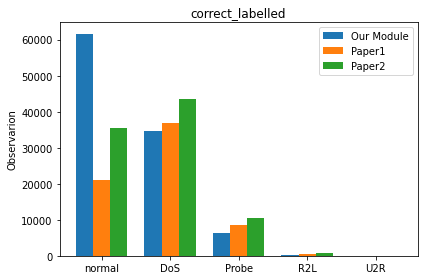

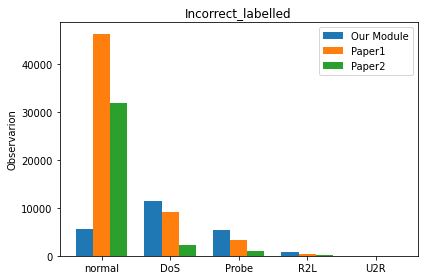

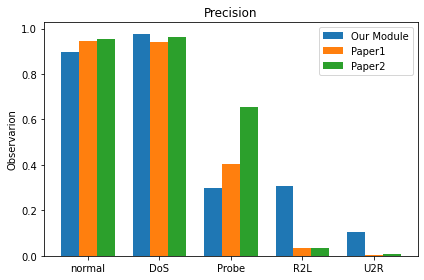

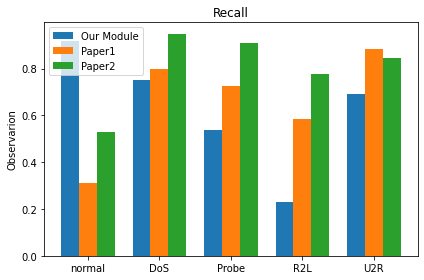

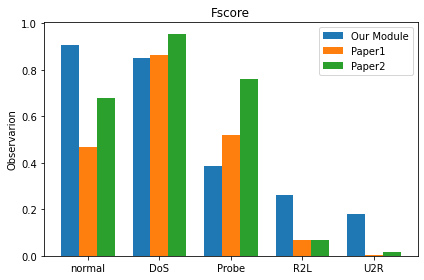

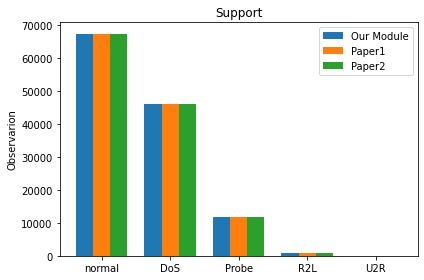

In [8]:
## Plotting Training results:

#correct_labelled
plotBased(results1.iloc[:,1], results2.iloc[:,1], results3.iloc[:,1], 'correct_labelled')

#Incorrect_labelled
plotBased(results1.iloc[:,2], results2.iloc[:,2], results3.iloc[:,2], 'Incorrect_labelled')

#Precision
plotBased(resultsDataFrame1.iloc[0,1:], resultsDataFrame2.iloc[0,1:], resultsDataFrame3.iloc[0,1:], 'Precision')

#Recall
plotBased(resultsDataFrame1.iloc[1,1:], resultsDataFrame2.iloc[1,1:], resultsDataFrame3.iloc[1,1:], 'Recall')

#Fscore
plotBased(resultsDataFrame1.iloc[2,1:], resultsDataFrame2.iloc[2,1:], resultsDataFrame3.iloc[2,1:], 'Fscore')

#Support
plotBased(resultsDataFrame1.iloc[3,1:], resultsDataFrame2.iloc[3,1:], resultsDataFrame3.iloc[3,1:], 'Support')

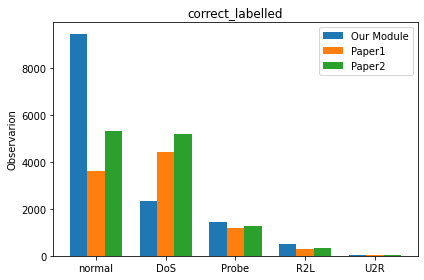

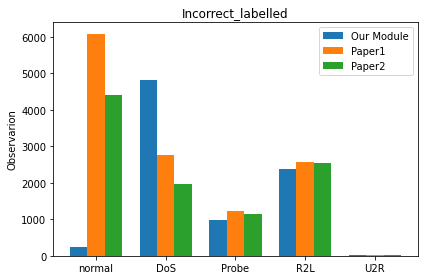

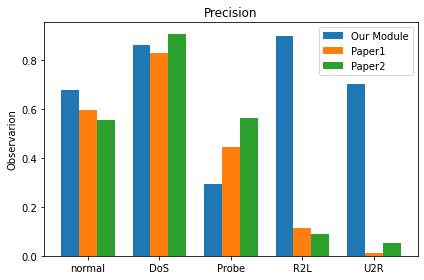

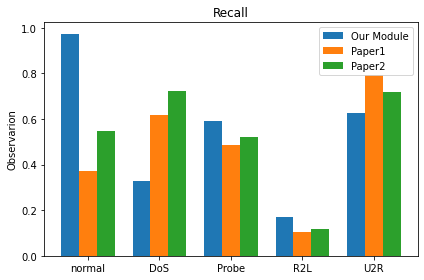

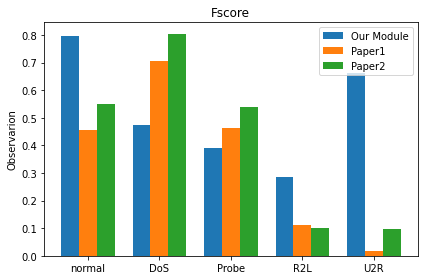

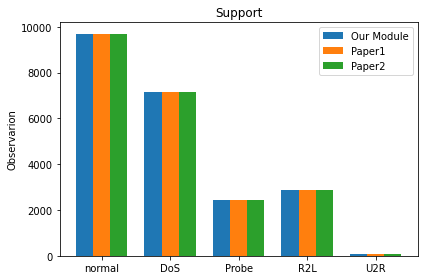

In [9]:
## Plotting Testing results:

#correct_labelled
plotBased(results1Test.iloc[:,1], results2Test.iloc[:,1], results3Test.iloc[:,1], 'correct_labelled')

#Incorrect_labelled
plotBased(results1Test.iloc[:,2], results2Test.iloc[:,2], results3Test.iloc[:,2], 'Incorrect_labelled')

#Precision
plotBased(resultsDataFrame1Test.iloc[0,1:], resultsDataFrame2Test.iloc[0,1:], resultsDataFrame3Test.iloc[0,1:], 'Precision')

#Recall
plotBased(resultsDataFrame1Test.iloc[1,1:], resultsDataFrame2Test.iloc[1,1:], resultsDataFrame3Test.iloc[1,1:], 'Recall')

#Fscore
plotBased(resultsDataFrame1Test.iloc[2,1:], resultsDataFrame2Test.iloc[2,1:], resultsDataFrame3Test.iloc[2,1:], 'Fscore')

#Support
plotBased(resultsDataFrame1Test.iloc[3,1:], resultsDataFrame2Test.iloc[3,1:], resultsDataFrame3Test.iloc[3,1:], 'Support')

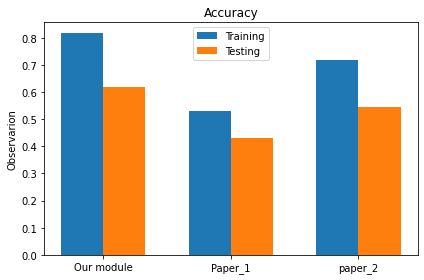

In [11]:
labels = ['Our module', 'Paper_1', 'paper_2']

x = np.arange(len(labels))  # the label locations
width = 0.33  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [ourModelTrainingAcc,Paper1TrainingAcc,Paper2TrainingAcc], width, label='Training')
rects2 = ax.bar(x + width/2, [ourModelTestingAcc,Paper1TestingAcc,Paper2TestingAcc], width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Observarion')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(array1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()